In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.autoencoder import Autoencoder

import numpy as np
import os

%load_ext autoreload
%autoreload 2


TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'autoencoder-lstm')

In [2]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [3]:
def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [4]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [5]:
IMAGE_SZ = (64, 64)
BATCH_SZ = 2
NUM_WORKERS = 4
MAX_FRAMES = 10
TRANSFORMS = transform=transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])

train_set = TGIF(
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/train',
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS,
)

val_set = TGIF(
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/val',
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS,
)

test_set = TGIF(
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/test',
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS,
)

overfit_train_set = DataLoader(train_set, 
                               batch_size=BATCH_SZ, 
                               num_workers=NUM_WORKERS, 
                               drop_last=True,
                               sampler=sampler.SubsetRandomSampler([i for i in range(178, 178 + BATCH_SZ)]))


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set), len(test_set))

3995 750 250


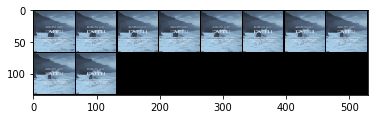

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
gif = dataiter.next()[0]

def imshow(img, save_file=None):
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))

    if save_file:
        plt.imsave(save_file, out)
        
    plt.imshow(out)
    
imshow(torchvision.utils.make_grid(gif))

# indx = 0
# try:
#     for i in range(3668, len(train_set)):
#         if i % 200 == 0:
#             print(i)
#         indx = i
#         x = train_set[i]

# except ValueError:
#     print(indx, train_set.filenames[indx])

    


In [9]:
def train_fn(model, optimizer, inp):
    
#     def loss_fn(a, b): 
#         a1 = a.view(a.shape[0], -1)
#         b1 = b.view(b.shape[0], -1) 
        
#         losses = torch.sum((a1 - b1)**2, dim=1)
#         return torch.mean(losses)
    
    def mse_loss(inp, target):
        return torch.sum((inp - target) ** 2) / inp.shape[0]

    loss_fn = mse_loss #nn.MSELoss()
    
    model.train()         
    
    x = inp[:, 0, :, :, :]

    x = x.to(device=device, dtype=dtype)

    y = model(x)
    
#     print('---', x.shape, y.shape)

    loss = loss_fn(x, y)

    loss.cuda().backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    return loss.item()

## Train network

In [13]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


net = Autoencoder(device=device)

# optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, nesterov=True)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [14]:
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH)


print('Starting training...')
trainer.train(overfit_train_set, epochs=1000, save_every=20)

Starting training...
Epoch [0] (0/1), loss = 4510.990723
Epoch [1] (0/1), loss = 3109.489746
Epoch [2] (0/1), loss = 2367.459717
Epoch [3] (0/1), loss = 1836.900513
Epoch [4] (0/1), loss = 1401.821655
Epoch [5] (0/1), loss = 1021.430298
Epoch [6] (0/1), loss = 734.015320
Epoch [7] (0/1), loss = 502.429565
Epoch [8] (0/1), loss = 339.918854
Epoch [9] (0/1), loss = 230.673203
Epoch [10] (0/1), loss = 168.746094
Epoch [11] (0/1), loss = 143.987610
Epoch [12] (0/1), loss = 144.974991
Epoch [13] (0/1), loss = 161.587830
Epoch [14] (0/1), loss = 182.632431
Epoch [15] (0/1), loss = 199.231003
Epoch [16] (0/1), loss = 209.130371
Epoch [17] (0/1), loss = 210.575256
Epoch [18] (0/1), loss = 197.748260
Epoch [19] (0/1), loss = 190.294540
Epoch [20] (0/1), loss = 176.660904
Epoch [21] (0/1), loss = 156.217194
Epoch [22] (0/1), loss = 137.694351
Epoch [23] (0/1), loss = 119.983215
Epoch [24] (0/1), loss = 107.373604
Epoch [25] (0/1), loss = 102.110664
Epoch [26] (0/1), loss = 97.517281
Epoch [27] (

Epoch [231] (0/1), loss = 7.015380
Epoch [232] (0/1), loss = 7.026091
Epoch [233] (0/1), loss = 6.967617
Epoch [234] (0/1), loss = 7.095200
Epoch [235] (0/1), loss = 7.252198
Epoch [236] (0/1), loss = 7.295063
Epoch [237] (0/1), loss = 7.578387
Epoch [238] (0/1), loss = 7.565238
Epoch [239] (0/1), loss = 7.373343
Epoch [240] (0/1), loss = 6.870811
Epoch [241] (0/1), loss = 6.623107
Epoch [242] (0/1), loss = 6.809130
Epoch [243] (0/1), loss = 7.002429
Epoch [244] (0/1), loss = 7.023314
Epoch [245] (0/1), loss = 6.680450
Epoch [246] (0/1), loss = 6.530554
Epoch [247] (0/1), loss = 6.636830
Epoch [248] (0/1), loss = 6.862802
Epoch [249] (0/1), loss = 6.836196
Epoch [250] (0/1), loss = 6.722430
Epoch [251] (0/1), loss = 6.587961
Epoch [252] (0/1), loss = 6.395585
Epoch [253] (0/1), loss = 6.287462
Epoch [254] (0/1), loss = 6.293575
Epoch [255] (0/1), loss = 6.379760
Epoch [256] (0/1), loss = 6.346257
Epoch [257] (0/1), loss = 6.269711
Epoch [258] (0/1), loss = 6.043695
Epoch [259] (0/1), l

Epoch [466] (0/1), loss = 3.128983
Epoch [467] (0/1), loss = 3.109522
Epoch [468] (0/1), loss = 3.068853
Epoch [469] (0/1), loss = 3.039677
Epoch [470] (0/1), loss = 3.016752
Epoch [471] (0/1), loss = 3.006207
Epoch [472] (0/1), loss = 3.016615
Epoch [473] (0/1), loss = 2.997681
Epoch [474] (0/1), loss = 2.977644
Epoch [475] (0/1), loss = 2.973613
Epoch [476] (0/1), loss = 2.950640
Epoch [477] (0/1), loss = 2.938370
Epoch [478] (0/1), loss = 2.922442
Epoch [479] (0/1), loss = 2.923127
Epoch [480] (0/1), loss = 2.905098
Epoch [481] (0/1), loss = 2.898705
Epoch [482] (0/1), loss = 2.882471
Epoch [483] (0/1), loss = 2.883456
Epoch [484] (0/1), loss = 2.866295
Epoch [485] (0/1), loss = 2.862273
Epoch [486] (0/1), loss = 2.849229
Epoch [487] (0/1), loss = 2.839329
Epoch [488] (0/1), loss = 2.841731
Epoch [489] (0/1), loss = 2.836417
Epoch [490] (0/1), loss = 2.826679
Epoch [491] (0/1), loss = 2.833866
Epoch [492] (0/1), loss = 2.834745
Epoch [493] (0/1), loss = 2.872955
Epoch [494] (0/1), l

Epoch [701] (0/1), loss = 2.821431
Epoch [702] (0/1), loss = 3.624654
Epoch [703] (0/1), loss = 3.464732
Epoch [704] (0/1), loss = 3.353284
Epoch [705] (0/1), loss = 2.899238
Epoch [706] (0/1), loss = 2.376907
Epoch [707] (0/1), loss = 2.879024
Epoch [708] (0/1), loss = 2.943356
Epoch [709] (0/1), loss = 2.948142
Epoch [710] (0/1), loss = 2.806730
Epoch [711] (0/1), loss = 2.558532
Epoch [712] (0/1), loss = 2.447189
Epoch [713] (0/1), loss = 2.664871
Epoch [714] (0/1), loss = 2.325412
Epoch [715] (0/1), loss = 2.426667
Epoch [716] (0/1), loss = 2.257817
Epoch [717] (0/1), loss = 2.237633
Epoch [718] (0/1), loss = 2.207808
Epoch [719] (0/1), loss = 2.088234
Epoch [720] (0/1), loss = 2.173805
Epoch [721] (0/1), loss = 2.029621
Epoch [722] (0/1), loss = 2.062688
Epoch [723] (0/1), loss = 2.075663
Epoch [724] (0/1), loss = 1.983454
Epoch [725] (0/1), loss = 2.011839
Epoch [726] (0/1), loss = 1.946998
Epoch [727] (0/1), loss = 1.971918
Epoch [728] (0/1), loss = 1.922639
Epoch [729] (0/1), l

Epoch [936] (0/1), loss = 1.418117
Epoch [937] (0/1), loss = 1.400941
Epoch [938] (0/1), loss = 1.396999
Epoch [939] (0/1), loss = 1.400799
Epoch [940] (0/1), loss = 1.421316
Epoch [941] (0/1), loss = 1.423286
Epoch [942] (0/1), loss = 1.418210
Epoch [943] (0/1), loss = 1.403523
Epoch [944] (0/1), loss = 1.410838
Epoch [945] (0/1), loss = 1.421301
Epoch [946] (0/1), loss = 1.421839
Epoch [947] (0/1), loss = 1.400840
Epoch [948] (0/1), loss = 1.384777
Epoch [949] (0/1), loss = 1.390328
Epoch [950] (0/1), loss = 1.417494
Epoch [951] (0/1), loss = 1.419816
Epoch [952] (0/1), loss = 1.425515
Epoch [953] (0/1), loss = 1.400533
Epoch [954] (0/1), loss = 1.400265
Epoch [955] (0/1), loss = 1.417339
Epoch [956] (0/1), loss = 1.437506
Epoch [957] (0/1), loss = 1.445489
Epoch [958] (0/1), loss = 1.457062
Epoch [959] (0/1), loss = 1.454076
Epoch [960] (0/1), loss = 1.475961
Epoch [961] (0/1), loss = 1.489398
Epoch [962] (0/1), loss = 1.539304
Epoch [963] (0/1), loss = 1.499302
Epoch [964] (0/1), l

In [15]:
# trainer.save_models = True
# trainer.save_data()

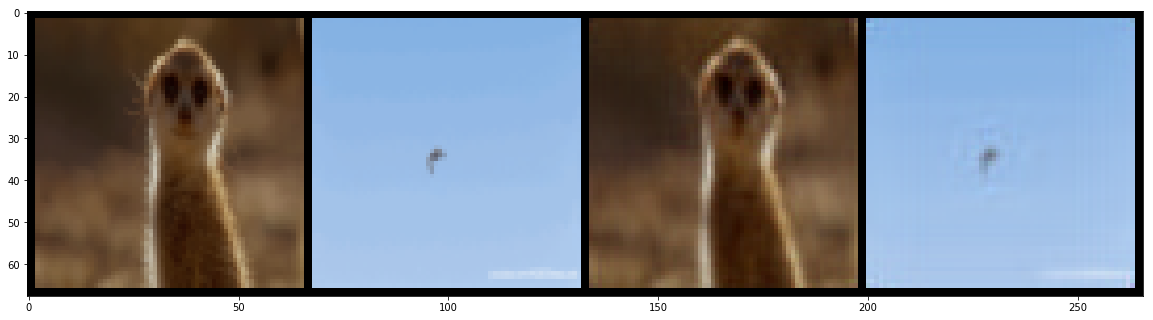

In [17]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y   # TODO: maybe sample from probability?
        ret.append(y.to(device = torch.device('cpu')))
        
    
    return torch.stack(ret).transpose(0, 1)


plt.figure(figsize=(20,40))

    
def test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    x = x[:, 0, :, :, :]

    x = x.to(device=device, dtype=dtype)

    
    
    y = model(x)
    
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    
    imgs = torch.cat([x, y])
    

#     plt.subplot(211)
#     imshow(torchvision.utils.make_grid(x)) #, save_file='img/train_test_orig.png')
#     plt.subplot(212)
    
#     imshow(torchvision.utils.make_grid(y)) #, save_file='img/train_test_out.png')
    imshow(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
    
    
    
    
    

test_autoenc(net, overfit_train_set)